# Predicting Coronal Mass Ejections Using SDO/HMI Vector Magnetic Data Products and Recurrent Neural Networks

Hao Liu, Chang Liu, Jason T. L. Wang, and Haimin Wang

Institute for Space Weather Sciences, New Jersey Institute of Technology

## 1. Introduction

Coronal mass ejections (CMEs) are intense bursts of magnetic flux and plasma that are ejected from the Sun into interplanetary space. They are often associated with solar flares and originate from active regions (ARs) on the Sun’s photosphere where magnetic fields are strong and evolve rapidly. Major CMEs and their associated flares can cause severe influences on the near-Earth environment, resulting in potentially life-threatening consequences. Therefore, substantial efforts are being invested in developing new technologies for early detection and forecasting of flares and CMEs.

In this notebook, we demonstrate 2 machine learning models to predict whether an AR that produces an M- or X-class flare will also produce a CME. The machine learning algorithms which we use include two types of recurrent neural networks (RNNs): a long short-term memory (LSTM) network and a gated recurrent unit (GRU) network. We show the models' prediction for various time windows (T), where T is the amount of time between the initial CME and the subsequent M- or X-class flare; using data from the National Centers for
Environmental Information (NCEI) data catalog for years 2015-2019. The models were trained on NCEI data from years 2010-2014.

## 2. Workflow of CMEPredict

### 2.1. Configuration

In [1]:
import sys
sys.path.insert(0, './CMEpredict')

from CMEpredict import *

import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
from sklearn.metrics import confusion_matrix as cm, roc_curve, roc_auc_score

In [2]:
mask_value = 0
series_len = 20
epochs = 20
batch_size = 256
nclass = 2
start_feature = 4

### 2.2. Definition of features

There are 18 features, or predictive parameters, which characterize AR magnetic field properties for CME predictions:

1. **MEANPOT**: mean photospheric magnetic free energy
1. **SHRGT45**: fraction of area with shear >45°
1. **TOTPOT**: total photospheric magnetic free energy density
1. **USFLUX**: total unsigned flux
1. **MEANJZH**: mean current helicity
1. **ABSNJZH**: absolute value of the net current helicity
1. **SAVNCPP**: sum of the modulus of the net current per polarity
1. **MEANALP**: mean characteristic twist parameter
1. **MEANSHR**: mean shear angle
1. **TOTUSJZ**: total unsigned vertical current
1. **TOTUSJH**: total unsigned current helicity
1. **MEANGAM**: mean angle of field from radial
1. **MEANGBZ**: mean gradient of vertical field
1. **MEANJZD**: mean vertical current density
1. **AREA_ACR**: area of strong field pixels in the active region
1. **R_VALUE**: sum of flux near polarity inversion line
1. **MEANGBT**: mean gradient of total field
1. **MEANGBH**: mean gradient of horizontal field

### 2.3. Data Explanation and Sampling

The NCEI data has 21 columns:

The **Label** column has 3 values: _padding_, _N_, and _P_. _Padding_ means this is an auxiliary data sample used to construct time series for prediction. _N_ means there is a >=M class flare within the next x hours but the flare is not associated with a CME. _P_ means there is a >=M class flare within the next x hours and this flare is associated with a CME.

The **NOAA AR NUM** and **HARP NUM** columns are identifying columns for the AR and HARP, respectively. 

The subsequent 18 columns are the 18 physical SHARP features.

In [3]:
names = ['Label', 'Timestamp', 'NOAA AR NUM', 'HARP NUM',
          'TOTUSJH', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP', 'USFLUX', 'AREA_ACR',
          'MEANPOT', 'R_VALUE', 'SHRGT45', 'MEANGAM', 'MEANJZH', 'MEANGBT', 'MEANGBZ',
          'MEANJZD', 'MEANGBH', 'MEANSHR', 'MEANALP']
sample_data = pd.read_csv('CMEpredict/normalized_testing_12.csv', names=names)
display(sample_data)

,Label,Timestamp,NOAA AR NUM,HARP NUM,TOTUSJH,TOTPOT,TOTUSJZ,ABSNJZH,SAVNCPP,USFLUX,...,R_VALUE,SHRGT45,MEANGAM,MEANJZH,MEANGBT,MEANGBZ,MEANJZD,MEANGBH,MEANSHR,MEANALP
0,padding,2016-02-10T22:58:09.80Z,12497,6327,-0.0759,0.3866,-0.4445,-0.2113,-0.2948,1.0499,...,-0.1779,0.6987,0.9725,-0.2374,1.0638,0.1487,0.3849,0.7120,0.4456,0.5940
1,padding,2016-02-10T23:10:09.90Z,12497,6327,-0.0967,0.3649,-0.4693,-0.2790,-0.2643,0.8327,...,-0.1750,0.6904,0.9770,-0.2408,1.0778,0.1603,0.4032,0.7052,0.4429,0.5805
2,padding,2016-02-10T23:22:09.90Z,12497,6327,-0.0904,0.3496,-0.4161,-0.1743,-0.3262,1.1293,...,-0.1774,0.6946,1.0026,-0.2407,1.0963,0.1505,0.3940,0.7061,0.4253,0.5744
3,padding,2016-02-10T23:34:09.90Z,12497,6327,-0.1058,0.3376,-0.4049,-0.1645,-0.3412,1.0525,...,-0.1792,0.6842,1.0105,-0.2502,1.0994,0.1434,0.3821,0.7030,0.4073,0.5478
4,padding,2016-02-10T23:46:09.90Z,12497,6327,-0.1035,0.3401,-0.4028,-0.1468,-0.3443,1.2058,...,-0.1840,0.6868,0.9994,-0.2505,1.0996,0.1362,0.3983,0.7010,0.4176,0.5561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,P,2016-04-17T23:34:41.00Z,12529,6483,0.9327,0.4485,0.4513,0.2630,-0.5814,-0.0546,...,1.2833,0.7819,-0.5989,1.3702,-0.6397,0.6014,0.4179,0.3667,0.5072,0.3309
717,P,2016-04-17T23:46:41.00Z,12529,6483,0.9399,0.4514,0.5107,0.2952,-0.6123,0.1997,...,1.2744,0.7709,-0.5941,1.3693,-0.6519,0.5919,0.4060,0.3666,0.5179,0.3272
718,P,2016-04-17T23:58:41.00Z,12529,6483,0.9489,0.4705,0.5293,0.3388,-0.6220,0.0527,...,1.2723,0.7757,-0.5994,1.3751,-0.6525,0.5842,0.4039,0.3666,0.5335,0.3327
719,P,2016-04-18T00:10:41.00Z,12529,6483,0.9428,0.4584,0.5930,0.5310,-0.6540,0.1240,...,1.2669,0.7690,-0.6131,1.3667,-0.6636,0.5667,0.3828,0.3631,0.5160,0.3352


### 2.4 Prediction and Analysis

#### 2.4.1. Predicting with Pre-Trained Models

Each model `(rnn_type,time_window)` tuple differs in what the threshold for the probability is to consider it a Positive (P) result, if it's below this threshold then it's a Negative (N) result. We use this threshold in order to convert this into a Binary Classification problem.

Additionally, each `(rnn_type,time_window)` tuple has its own count of top features which are used in the model prediction. Our research has shown that for each tuple<sub>i</sub> the top N<sub>i</sub> features achieved the best performance.

predicting for 12 hour window using gru


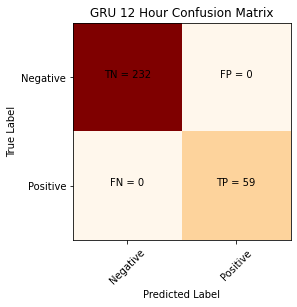

predicting for 12 hour window using lstm


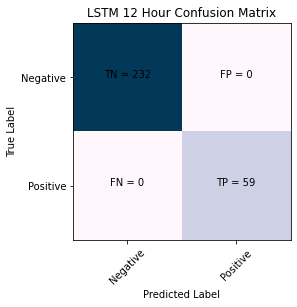

predicting for 36 hour window using gru


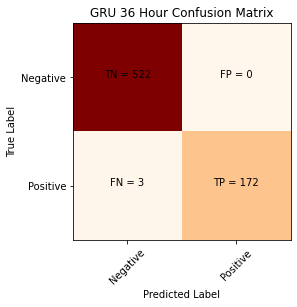

predicting for 36 hour window using lstm


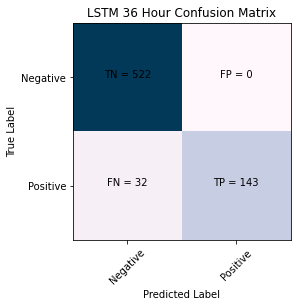

predicting for 60 hour window using gru


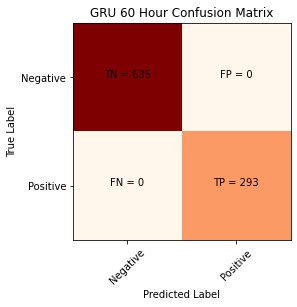

predicting for 60 hour window using lstm


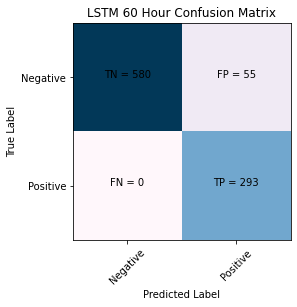

In [4]:
import itertools
time_windows = [12, 36, 60] # options are 12, 24, 36, 48, 60
rnn_types = ['gru', 'lstm']
cm_grid = [['TN','FP'], ['FN', 'TP']]

results = {}

for (time_window, type) in itertools.product(time_windows, rnn_types):
    print(f'predicting for {time_window} hour window using {type}')
    model_file = f'CMEpredict/{type}-{time_window}-model.h5'

    n_features, threshold = get_n_features_thresh(type, time_window)

    model = load_model(model_file)

    test_data_file = f'CMEpredict/normalized_testing_{time_window}.csv'
    X_test, y_test, nb_test = load_data(datafile=test_data_file,
                                        series_len=series_len,
                                        start_feature=start_feature,
                                        n_features=n_features,
                                        mask_value=mask_value,
                                        type=type,
                                        time_window=time_window)

    prob = model.predict(X_test,
                        batch_size=batch_size,
                        verbose=False,
                        steps=None)

    bc = [1 if p >= threshold else 0 for p in prob]
    confmat = cm(y_test, bc)
    results[f'{type} {time_window}'] = (y_test, bc)
    plt.imshow(confmat, interpolation='nearest', cmap=(plt.cm.PuBu if type =='lstm' else plt.cm.OrRd))
    classNames = ['Negative','Positive']
    plt.title(f'{type.upper()} {time_window} Hour Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    for i in range(2):
        for j in range(2):
            plt.text(j,i, f'{cm_grid[i][j]} = {confmat[i][j]}', horizontalalignment='center')
    plt.show()

#### 2.4.2. Analysis of Predictions


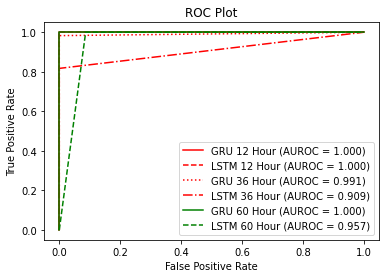

In [5]:
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y', 'c', 'k']) *
                           cycler('linestyle', ['-', '--', ':', '-.'])))
for name, (y_test, bc) in results.items():
    r_auc = roc_auc_score(y_test, bc)
    r_fpr, r_tpr, _ = roc_curve(y_test, bc)
    plt.plot(r_fpr, r_tpr, label=f'{name.upper()} Hour (AUROC = %0.3f)' % r_auc)
plt.title('ROC Plot')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend() 

plt.show()

### 2.5. Train your own model

In order to train your own model, change the appropriate variables below; run the cell; and rerun the prediction cells above. The new model will overwrite the pre-trained model file.

In [6]:
# CHANGE THESE VARIABLES#
time_window = 12        # 12, 24, 36, 48, 60
type = 'lstm'           # 'lstm', 'gru'
#########################

train_data_file = f'CMEpredict/normalized_training_{time_window}.csv'
n_features, thresh = get_n_features_thresh(type, time_window)
X_train, y_train, nb_train = load_data(datafile=train_data_file,
                                        series_len=series_len,
                                        start_feature=start_feature,
                                        n_features=n_features,
                                        mask_value=mask_value,
                                        type=type,
                                        time_window=time_window)

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_ = {0: class_weights[0], 1: class_weights[1]}

if type is 'lstm':
    model = lstm(n_features, series_len)  
elif type  is 'gru':
    model = gru(n_features, series_len)

print('training the model, wait until it is finished...')
model.compile(loss='binary_crossentropy',
                optimizer='RMSprop',
                metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=False,
                    shuffle=True,
                    class_weight=class_weight_)
model_file = f'CMEpredict/{type}-{time_window}-model.h5'
model.save(model_file)
print('done training the model')

training the model, wait until it is finished...
done training the model


## 3. References

Predicting Coronal Mass Ejections Using SDO/HMI Vector Magnetic Data Products and Recurrent Neural Networks. Liu, H., Liu, C., Wang, J. T. L., Wang, H., ApJ., 890:12, 2020  

https://iopscience.iop.org/article/10.3847/1538-4357/ab6850

https://arxiv.org/abs/2002.10953

https://web.njit.edu/~wangj/RNNcme/